 ## A simple convolutional neural net for classification of MNIST dataset

File my_batch contains class MnistBatch whith a simple CNN model named 'convy' and several methods:
 - load for loading data
 - train_convy which trains convy model
 - update_stats 
 - predict
 - shift_flattened_pic which applies random shift to every pic in the batch
 
In this notebook we will train CNN model stable to shift of the input images.

In [1]:
import os
import sys
import blosc

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

sys.path.append("..")
from dataset import DatasetIndex, Dataset
from my_batch import MnistBatch
from my_batch import draw_stats, draw_digit

## Load data

In [2]:
%matplotlib inline
%env CUDA_VISIBLE_DEVICES=[]
src = './../task_03//'
with open(os.path.join(src, 'mnist_pics.blk'), 'rb') as file:
    full_imgs = blosc.unpack_array(file.read())
    
with open(os.path.join(src, 'mnist_labels.blk'), 'rb') as file:
    full_labs = blosc.unpack_array(file.read())
    
src = (full_imgs, full_labs)

env: CUDA_VISIBLE_DEVICES=[]


## Create dataset using MnistBatch

In [3]:
LEN_MNIST = 65000
indy = DatasetIndex(np.arange(LEN_MNIST))

mnistset = Dataset(indy, batch_class=MnistBatch)
mnistset.cv_split([0.9, 0.1])

bch = MnistBatch(indy.create_subset(indy.indices[1:5]))

## Create session

In [4]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
stats = []

## Train on the original data

In [5]:
# pipeline for train
ppl = mnistset.train.pipeline() \
                    .load(src=src, fmt='ndarray') \
                    .train_convy(sess)

# pipeline for test
ppl_test = mnistset.test.pipeline() \
                        .load(src=src, fmt='ndarray') \
                        .update_stats(sess, stats)

In [6]:
for i in tqdm(range(400)):
    ppl.next_batch(100, n_epochs=None)
    ppl_test.next_batch(100, n_epochs=None)

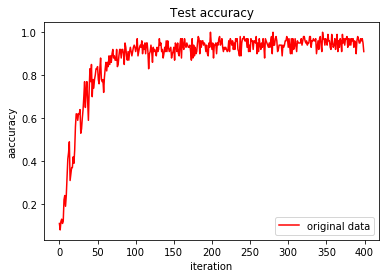

In [7]:
draw_stats([stats], ['original data'], 'Test accuracy')

## Test on shifted data

In [8]:
new_stats = []
ppl_test_shift = mnistset.test.pipeline() \
                              .load(src=src, fmt='ndarray') \
                              .shift_flattened_pic() \
                              .update_stats(sess, new_stats)

In [9]:
for i in tqdm(range(400)):
    ppl_test_shift.next_batch(100, n_epochs=None)

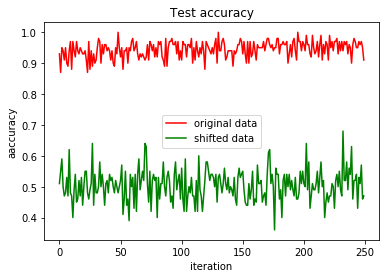

In [10]:
draw_stats([stats[150:], new_stats[150:400]], ['original data', 'shifted data'], 'Test accuracy')

So we see that a model trained on the original data performs poorly on the shifted data. Let's see where exactly it makes mistakes: 

In [53]:
pics = []
y_true = []
y_predict = []
probs = []

ppl_results = mnistset.test.pipeline() \
                           .load(src=src, fmt='ndarray') \
                           .shift_flattened_pic() \
                           .predict(sess, pics, y_true, y_predict, probs)

In [17]:
ppl_results.next_batch(100, n_epochs=None)

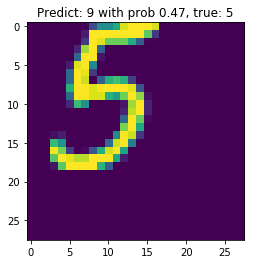

In [22]:
draw_digit(pics,y_predict, y_true, probs, answer=False)

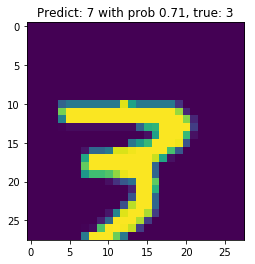

In [40]:
draw_digit(pics,y_predict, y_true, probs, answer=False)

## Train on shifted data

In [51]:
# pipeline for train
ppl_shift = mnistset.train.pipeline() \
                           .load(src=src, fmt='ndarray') \
                           .shift_flattened_pic() \
                           .train_convy(sess)

In [43]:
for i in tqdm(range(400)):
    ppl_shift.next_batch(100, n_epochs=None)
    ppl_test_shift.next_batch(100, n_epochs=None)

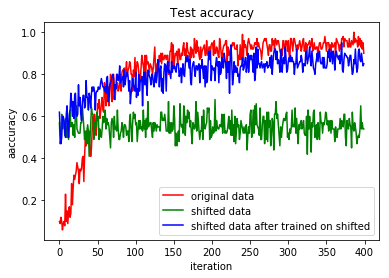

In [66]:
draw_stats([stats, new_stats[:400], new_stats[-400:]], ['original data', 'shifted data', 'shifted data after trained on shifted'], \
           'Test accuracy')

So we see that it's much better now.

Let's have a look on the digits:

In [54]:
pics = []
y_true = []
y_predict = []
probs = []
ppl_results = mnistset.test.pipeline() \
                           .load(src=src, fmt='ndarray') \
                           .shift_flattened_pic() \
                           .predict(sess, pics, y_true, y_predict, probs)

In [23]:
ppl_results.next_batch(100, n_epochs=None)

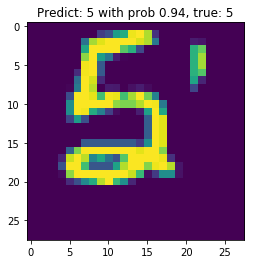

In [48]:
draw_digit(pics,y_predict, y_true, probs, answer=True)

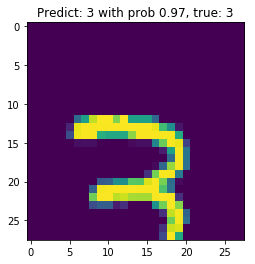

In [50]:
draw_digit(pics,y_predict, y_true, probs, answer=True)

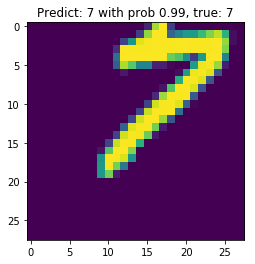

In [52]:
draw_digit(pics,y_predict, y_true, probs, answer=True)

In [59]:
print('Test accuracy on the original data: %.2f %%' % (100.0*np.mean(stats)))

Test accuracy on the original data: 82.08 %


In [62]:
print('Test accuracy on the shifted data: %.2f %%' % (100.0*np.mean(new_stats[:400])))
print('Test accuracy on the shifted data after trained on the shifted data: %.2f %%' % (100.0*np.mean(new_stats[-400:])))

Test accuracy on the shifted data: 55.31 %
Test accuracy on the shifted data after trained on the shifted data: 80.42 %
